In [397]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.spatial import ConvexHull
from scipy.stats import chi2_contingency
from collections import Counter
import spacy
from sklearn.feature_extraction.text import CountVectorizer


# Análise Exploratória de Dados

Autor: Lara Esquivel de Brito Santos

Neste notebook está descreve o passo a passo da análise exploratória dos dados imobiliários contidos no arquivo  teste_indicium_precificacao.csv

In [398]:
df = pd.read_csv('teste_indicium_precificacao.csv') #leitura do csv
df.head() #primeiros registros do dataframe

,id,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
0,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
1,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
2,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
3,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
4,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,2019-06-22,0.59,1,129


Cada coluna possui os seguintes tipos de dados, segundo o pandas:

In [399]:
df.dtypes

id                                 int64
nome                              object
host_id                            int64
host_name                         object
bairro_group                      object
bairro                            object
latitude                         float64
longitude                        float64
room_type                         object
price                              int64
minimo_noites                      int64
numero_de_reviews                  int64
ultima_review                     object
reviews_por_mes                  float64
calculado_host_listings_count      int64
disponibilidade_365                int64
dtype: object

- **id**: Embora seja um valor `int64`, é um identificador.
- **nome**: Nome do anúncio, variável **categórica nominal**.
- **host_id**: é um identificador do anfitrião.
- **host_name**: Variável **nominal**, representando o nome do anfitrião.
- **bairro_group**: Variável **nominal**, que categoriza os grupos de bairros.
- **latitude**: Variável **contínua**, representando uma coordenada geográfica.
- **longitude**: Variável **contínua**, representando uma coordenada geográfica.
- **room_type**: Variável **nominal**, descrevendo o tipo de quarto.
- **price**: Representa o preço do aluguel. Embora devesse ser uma variável **contínua** (podendo incluir valores decimais), nesta base de dados não possui valores decimais.
- **minimo_noite**: Variável **discreta**, pois conta o número mínimo de noites para o aluguel temporário.
- **numero_de_reviews**: Variável **discreta**, que representa a contagem de avaliações.
- **ultima_review**: É uma data. Porém, o pandas não reconheceu como tal e precisa ser convertida para o formato `datetime`.
- **reviews_por_mes**: Variável **contínua**, representando a média de avaliações mensais.
- **calculated_host_listings_count**: Variável **discreta**, pois é uma contagem.
- **disponibilidade**: Variável **discreta**, que indica o número de dias em que o anúncio está disponível para reserva.





Os nulos incluem os atributos nome do anúncio, o nome do hospedador do anúncio, a ultima review e as reviews por mês, incialmente não tratarei isto

In [400]:
df.isnull().sum() #mostrando o número de registros de cada coluna que possuem valor vazio

id                                   0
nome                                16
host_id                              0
host_name                           21
bairro_group                         0
bairro                               0
latitude                             0
longitude                            0
room_type                            0
price                                0
minimo_noites                        0
numero_de_reviews                    0
ultima_review                    10052
reviews_por_mes                  10052
calculado_host_listings_count        0
disponibilidade_365                  0
dtype: int64

## Analisando dados básicos para criar hipóteses

Considerando que o cliente quer um modelo de previsão de preços, o questionamento incial:  é como os atributos influenciam o preço? 

Os primeiros atributos que provavelmente afetam é o tipo de imóvel e o bairro, uma casa de três quartos e dois banheiros por ocupar uma área maior deveria ser mais cara que um apartamento de dois quartos e um banheiro, todavia o bairro do imóvel afeta esses valores, por característica do próprio bairro, como sendo mais distante do centro ou mais proximo de uma universidade.

Consequentemente latitude e longitude estão relacionadas ao bairro, o número total de reviews e as reviews por mês podem estar relacionadas ao bairro populares, onde as pessoas mais buscam. Enquanto a última review indica se o anuncio está ativo, reviews mais antigas podem ter o preço mais baixo. Enquanto disponibilidade está relacionada a sazionalidade e demanda, o que pode influenciar o preço tanto positivamente quanto negativamente.

In [401]:
df.select_dtypes(include=['number']).describe()

,id,host_id,latitude,longitude,price,minimo_noites,numero_de_reviews,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
count,4.889400e+04,4.889400e+04,48894.000000,48894.000000,48894.000000,48894.000000,48894.000000,38842.000000,48894.000000,48894.000000
mean,1.901753e+07,6.762139e+07,40.728951,-73.952169,152.720763,7.030085,23.274758,1.373251,7.144005,112.776169
std,1.098288e+07,7.861118e+07,0.054529,0.046157,240.156625,20.510741,44.550991,1.680453,32.952855,131.618692
min,2.595000e+03,2.438000e+03,40.499790,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,9.472371e+06,7.822737e+06,40.690100,-73.983070,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000
50%,1.967743e+07,3.079553e+07,40.723075,-73.955680,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000
75%,2.915225e+07,1.074344e+08,40.763117,-73.936273,175.000000,5.000000,24.000000,2.020000,2.000000,227.000000
max,3.648724e+07,2.743213e+08,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


In [402]:
df.select_dtypes(exclude=['number']).describe()

,nome,host_name,bairro_group,bairro,room_type,ultima_review
count,48878,48873,48894,48894,48894,38842
unique,47904,11452,5,221,3,1764
top,Hillside Hotel,Michael,Manhattan,Williamsburg,Entire home/apt,2019-06-23
freq,18,417,21661,3920,25409,1413


Em cima desses dados o que podemos perceber que temos valores discrepantes de preço, o menor valor é 0 doláres e o maior valor é 10.000 doláres. Inclusive são estranhos os registros cujo o valor de aluguel está como 0 de inicio, e da mesma forma para disponibilidade, isto pode ser ruídos na base de dados, ou o que pode ser cogitado é que é um imóvel comunitário por isso tem valor 0, enquanto a disponibilidade é o fato do anunciante ter tirado o anúncio de circuilação, ou não ter mais locações, isso corresponde ao primeiro quartil do conjunto de dados, não deve ser um ruído. 

Todavia quando fazemos um histograma usando os tipos de residência cujo o valor da locação é 0, é estranho porque ninguém colocaria um anúncio de imóvel para alugar por esse valor, cogitei que poderia ser algo de imóveis compartilhados comunitários mas o valor aparece entre outros tipos de imóveis. Por esse motivo, removi todos os registros cujo a locação tem valor 0.

In [403]:
df.room_type.unique()

array(['Entire home/apt', 'Private room', 'Shared room'], dtype=object)

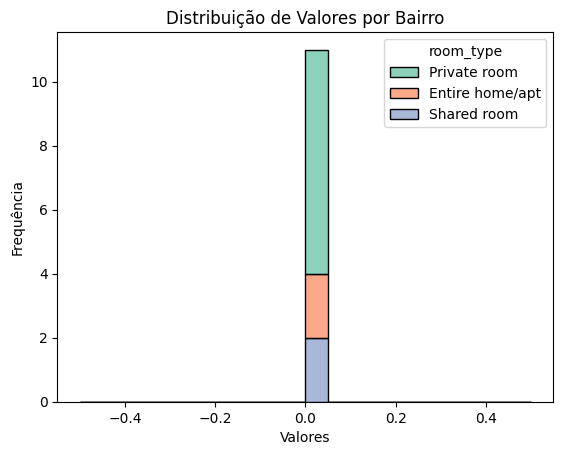

In [404]:
sns.histplot(data=df[df['price']==0], x='price', hue='room_type', multiple='stack', bins=20, palette='Set2')
plt.title('Distribuição de Valores por Bairro')
plt.xlabel('Valores')
plt.ylabel('Frequência')
plt.show()

In [405]:
df = df[df['price'] != 0]

Analisando o grupo de bairros por valor do aluguel decidi inicialmente criar um boxplot para verificar a distribuição dos dados e dos valores das locações, grupos de bairro porque temos 221 bairros registrados, e seria menos visivel inicialmente. Como na tabela de descrição gerada pelo pandas vemos a diferença entre o terceiro quartil e o valor máximo ($9825), já era esperado outliers, todavia devido a discrepança fiz dois boxplot, um para realmente ver essa estátistica e outro para ver a distribuição dentro dos grupos de bairros.

Todos os bairros tem valores exorbitantes, mas Manhattan e Brooklyn tem valores mais distribuídos e medianas maiores, ou seja tem mais imóveis com valors mais altos, do que os outros grupos de bairro.

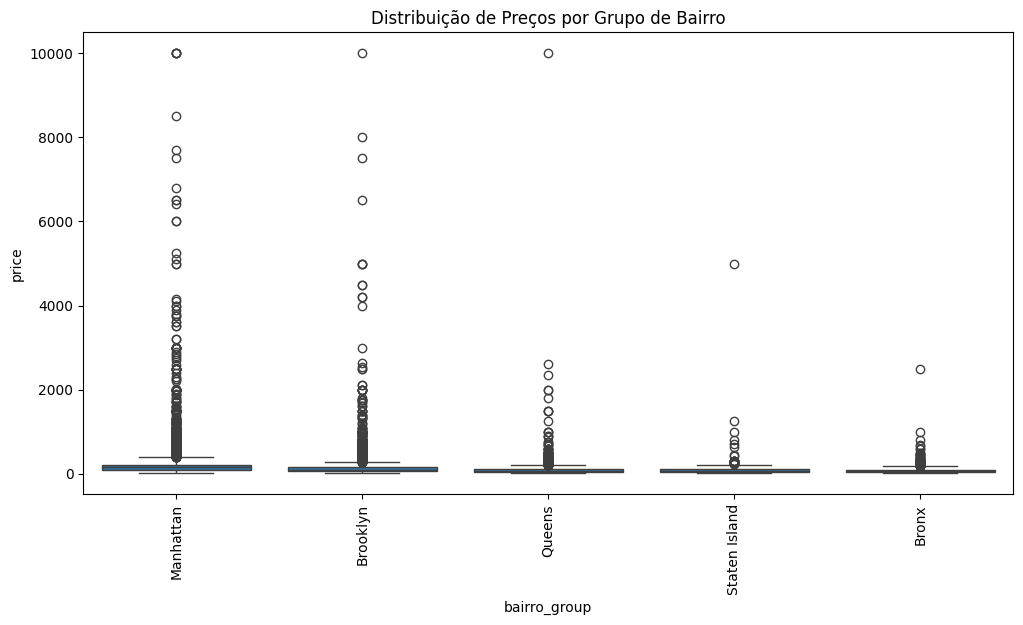

In [406]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='bairro_group', y='price', data=df)
plt.title('Distribuição de Preços por Grupo de Bairro')
plt.xticks(rotation=90)
plt.show()

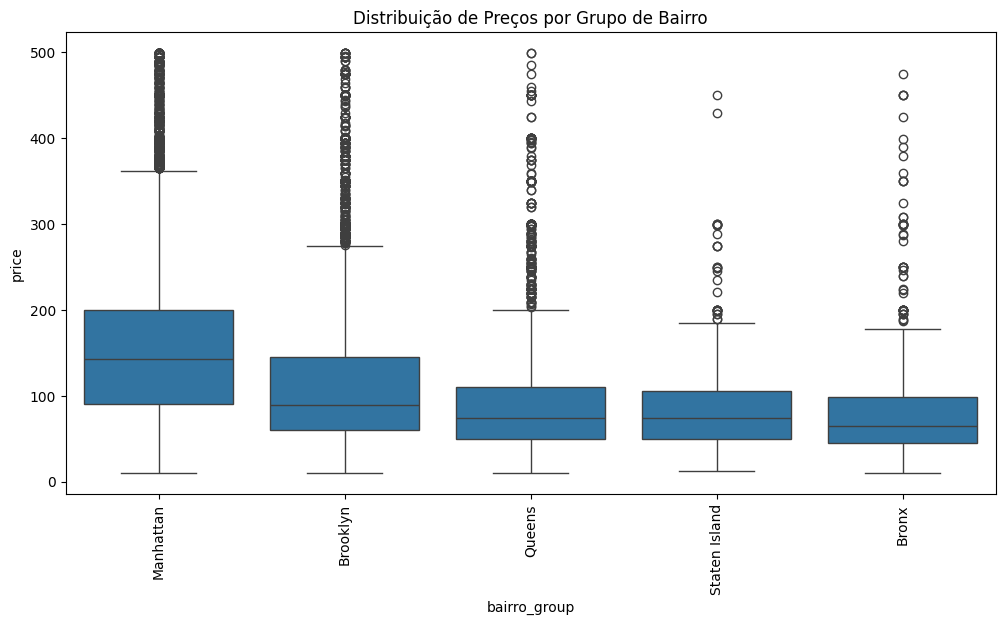

In [407]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='bairro_group', y='price', data=df[df['price'] < 500])
plt.title('Distribuição de Preços por Grupo de Bairro')
plt.xticks(rotation=90)
plt.show()

Dessa forma, pensei em plotar um histograma para ver como esses dados se distribuem ao longo dos valores, todavia a concentração abaixo de 1000 é muito maior, o que já era esperado dado a mediana e os terceiro quartil da coluna price. Dessa forma, plotei o histograma normalmente, para valores abaixo de 1000 e para os valores acima de 1000.

Podemos observar que:
    <li>O grupo Manhattan e Brooklyn está praticamente por todo o histograma </li>
    <li>Mas isso não ocorre com os outros grupos de bairros</li>
    <li>Então para quais bairros do grupo estão contidos dentro dessas faixas do histograma? Por exemplo quais bairros do Queens tem alguel no valor de $10000? Isso é um valor real ou um ruído da base de dados. Isso vale para cada grupo de bairro.</li>

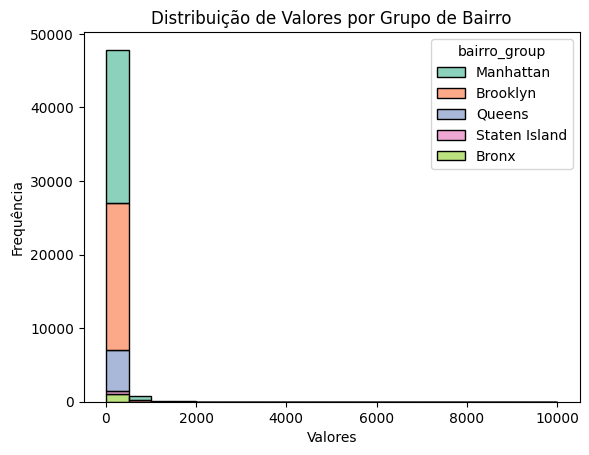

In [408]:
sns.histplot(data=df, x='price', hue='bairro_group', bins=20, multiple='stack', palette='Set2')
plt.title('Distribuição de Valores por Grupo de Bairro')
plt.xlabel('Valores')
plt.ylabel('Frequência')
plt.show()

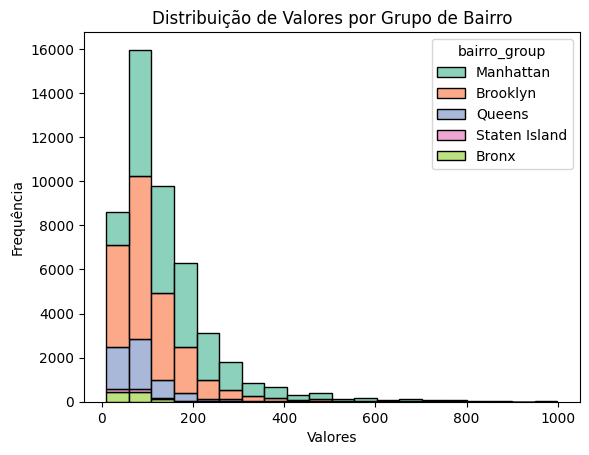

In [409]:
sns.histplot(data=df[df['price']<1000], x='price', hue='bairro_group', bins=20, multiple='stack', palette='Set2')
plt.title('Distribuição de Valores por Grupo de Bairro')
plt.xlabel('Valores')
plt.ylabel('Frequência')
plt.show()

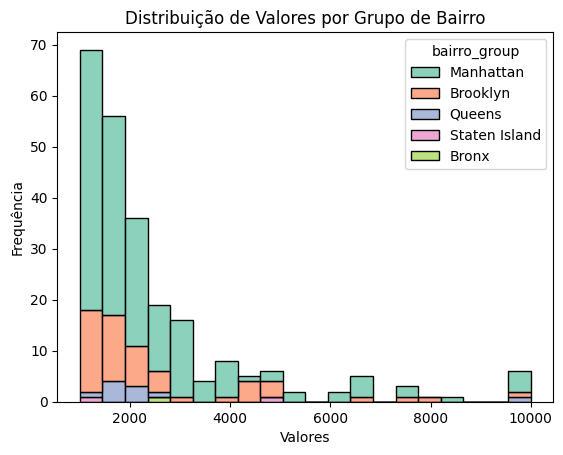

In [410]:
sns.histplot(data=df[df['price'] > 1000], x='price', hue='bairro_group', bins=20, multiple='stack', palette='Set2')
plt.title('Distribuição de Valores por Grupo de Bairro')
plt.xlabel('Valores')
plt.ylabel('Frequência')
plt.show()

Assim pensei incialmente um gráfico que pudesse representar os bairros e os valores dos imóveis desses bairros, todavia devido ao grande número de bairros dentro do grupo de bairros, optei por encontrar semelhanças inciais dentre os dados de coordenadas. Achei interessante a concentração de imóveis de alto padrão  no centro do gráfico (em torno da latitude 40,7) aparenta ter uma área de alto padrão naquela zona. Penso se esses imóveis por serem de alto padrão são alugados frequentemente? Se não são por serem caros? Existe muitas reviews sobre esses imóveis?

In [411]:
df.groupby('bairro_group')['bairro'].nunique()

bairro_group
Bronx            48
Brooklyn         47
Manhattan        32
Queens           51
Staten Island    43
Name: bairro, dtype: int64

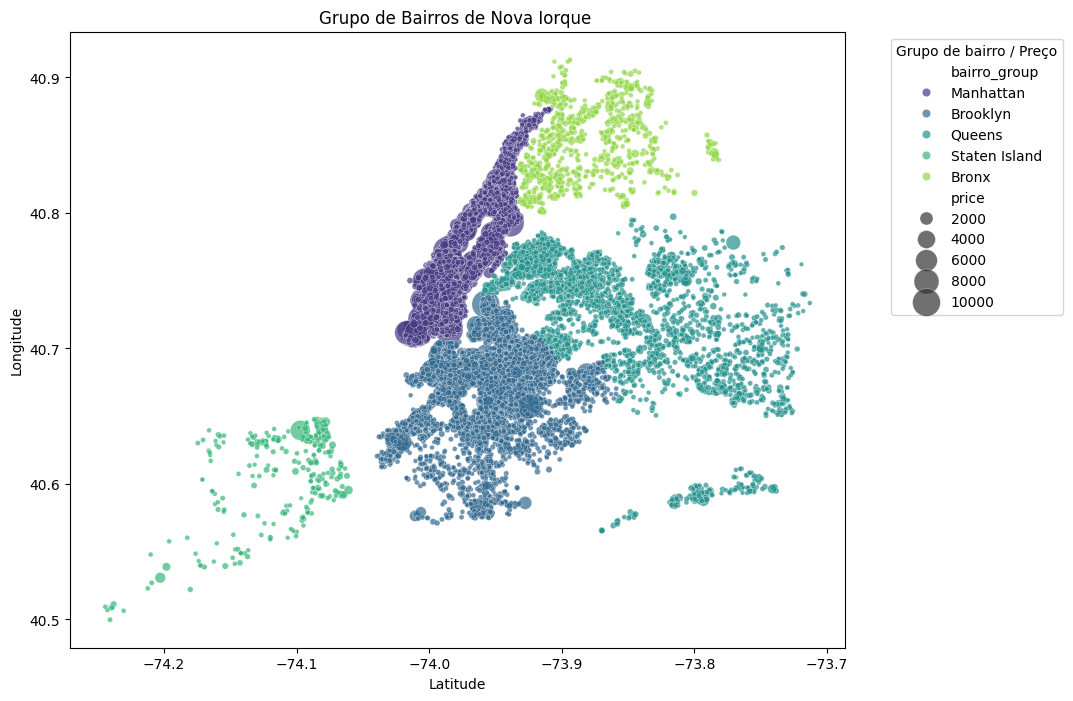

In [412]:
plt.figure(figsize=(10, 8))

sns.scatterplot(
    data=df, x='longitude', y='latitude', 
    size='price', sizes=(10, 400), hue='bairro_group', palette='viridis', alpha=0.7
)

plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.title("Grupo de Bairros de Nova Iorque ")
plt.legend(title='Grupo de bairro / Preço', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

Ao olhar melhor esses grupos de bairros, dados seus dados estatísticos descritos abaixo, o que podemos concluir:

* O Bronx é o grupo com a menor média de preço, no geral os imóveis são mais baratos 
* Todos os grupo de bairros possuem médias maiores que a mediana, o que mostra que a distribuição em todos os grupos de bairro possui uma calda para esquerda
* Manhattan possui a maior média e o maior desvio padrão, lembrando que maior parte dos imóveis está localizada em Manhattan, logo também possue a maior variedade de valores de imóveis.
* O Queens embora tenha imóveis de mais altos valores que o Staten Island, possui muitos imóveis de valores mais baixos e isso fez com que a média de preços do bairro caisse.
* Enquanto o State Island tem o maior valor mínimo de ímovel.
* Os imóveis de alto padrão do Queens e do Brooklyn estão ao redor de Manhattan

In [413]:
df[df['bairro_group'] == 'Bronx'].describe()


,id,host_id,latitude,longitude,price,minimo_noites,numero_de_reviews,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
count,1.090000e+03,1.090000e+03,1090.000000,1090.000000,1090.000000,1090.000000,1090.000000,875.000000,1090.00000,1090.000000
mean,2.273712e+07,1.055859e+08,40.848319,-73.884550,87.577064,4.563303,25.977982,1.837006,2.23211,165.794495
std,1.023846e+07,8.711597e+07,0.026725,0.032833,106.725371,15.638775,42.225003,1.674062,2.37106,135.304079
min,4.409600e+04,1.222100e+04,40.800110,-73.931900,10.000000,1.000000,0.000000,0.020000,1.00000,0.000000
25%,1.616891e+07,2.159430e+07,40.826628,-73.911068,45.000000,1.000000,1.000000,0.480000,1.00000,37.000000
50%,2.389267e+07,9.129115e+07,40.846205,-73.892585,65.000000,2.000000,9.000000,1.380000,1.00000,148.000000
75%,3.190046e+07,1.792933e+08,40.869618,-73.858413,99.000000,3.000000,32.000000,2.790000,2.00000,313.750000
max,3.644225e+07,2.738773e+08,40.913060,-73.781580,2500.000000,365.000000,321.000000,10.340000,37.00000,365.000000


In [414]:
df[df['bairro_group'] == 'Brooklyn'].describe()


,id,host_id,latitude,longitude,price,minimo_noites,numero_de_reviews,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
count,2.009400e+04,2.009400e+04,20094.000000,20094.000000,20094.000000,20094.000000,20094.000000,16437.000000,20094.000000,20094.000000
mean,1.825673e+07,5.671863e+07,40.685034,-73.951201,124.437693,6.055738,24.198417,1.283078,2.283119,100.204141
std,1.083501e+07,7.261212e+07,0.027401,0.025479,186.901408,17.635297,44.346333,1.516014,5.274623,126.269798
min,3.831000e+03,2.438000e+03,40.571150,-74.039420,10.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,8.700149e+06,5.611518e+06,40.672590,-73.963500,60.000000,2.000000,1.000000,0.180000,1.000000,0.000000
50%,1.887273e+07,2.291993e+07,40.687520,-73.951750,90.000000,3.000000,6.000000,0.660000,1.000000,28.000000
75%,2.785047e+07,7.900130e+07,40.704968,-73.935930,150.000000,5.000000,25.000000,1.980000,2.000000,188.000000
max,3.648506e+07,2.743076e+08,40.738900,-73.856760,10000.000000,999.000000,488.000000,14.000000,232.000000,365.000000


In [415]:
df[df['bairro_group'] == 'Manhattan'].describe()


,id,host_id,latitude,longitude,price,minimo_noites,numero_de_reviews,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
count,2.166000e+04,2.166000e+04,21660.000000,21660.000000,21660.000000,21660.000000,21660.000000,16632.000000,21660.000000,21660.000000
mean,1.877484e+07,6.783312e+07,40.765063,-73.974607,196.884903,8.579409,20.986565,1.272131,12.791874,111.984580
std,1.116818e+07,7.936533e+07,0.038463,0.022139,291.386838,24.051383,42.573021,1.628252,48.235813,132.678717
min,2.595000e+03,2.845000e+03,40.702340,-74.018510,10.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,9.160997e+06,8.525354e+06,40.731820,-73.991690,95.000000,1.000000,1.000000,0.170000,1.000000,0.000000
50%,1.911665e+07,3.065628e+07,40.760880,-73.980425,150.000000,3.000000,4.000000,0.610000,1.000000,36.000000
75%,2.954131e+07,1.069502e+08,40.795093,-73.953837,220.000000,6.000000,19.000000,1.890000,2.000000,230.000000
max,3.648724e+07,2.743213e+08,40.876650,-73.908550,10000.000000,1250.000000,607.000000,58.500000,327.000000,365.000000


In [416]:
df[df['bairro_group'] == 'Queens'].describe()

,id,host_id,latitude,longitude,price,minimo_noites,numero_de_reviews,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
count,5.666000e+03,5.666000e+03,5666.000000,5666.000000,5666.000000,5666.000000,5666.000000,4574.000000,5666.000000,5666.000000
mean,2.175500e+07,9.615680e+07,40.731531,-73.872775,99.517649,5.181433,27.700318,1.941200,4.060184,144.451818
std,1.037687e+07,8.424324e+07,0.040368,0.056988,167.102155,15.028725,51.955853,2.213108,12.445003,135.538597
min,1.293700e+04,3.211000e+03,40.565460,-73.959270,10.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,1.396042e+07,2.121601e+07,40.707410,-73.917420,50.000000,1.000000,1.000000,0.370000,1.000000,2.000000
50%,2.256460e+07,6.827146e+07,40.744790,-73.895045,75.000000,2.000000,7.000000,1.210000,1.000000,98.000000
75%,3.076880e+07,1.580312e+08,40.759780,-73.829602,110.000000,3.000000,32.000000,2.790000,3.000000,286.000000
max,3.648436e+07,2.742256e+08,40.797210,-73.712990,10000.000000,500.000000,629.000000,20.940000,103.000000,365.000000


In [417]:
df[df['bairro_group'] == 'Staten Island'].describe()

,id,host_id,latitude,longitude,price,minimo_noites,numero_de_reviews,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
count,3.730000e+02,3.730000e+02,373.000000,373.000000,373.000000,373.000000,373.000000,314.000000,373.000000,373.000000
mean,2.159747e+07,9.853360e+07,40.610225,-74.105805,114.812332,4.831099,30.941019,1.872580,2.319035,199.678284
std,1.039310e+07,7.954340e+07,0.032419,0.036400,277.620403,19.727605,44.830766,1.685495,1.915580,131.852000
min,4.288200e+04,1.552300e+04,40.499790,-74.244420,13.000000,1.000000,0.000000,0.020000,1.000000,0.000000
25%,1.553243e+07,2.505997e+07,40.593720,-74.123930,50.000000,1.000000,1.000000,0.702500,1.000000,78.000000
50%,2.297702e+07,9.249339e+07,40.621540,-74.089300,75.000000,2.000000,12.000000,1.410000,1.000000,219.000000
75%,3.008296e+07,1.581790e+08,40.634740,-74.081070,110.000000,3.000000,42.000000,2.615000,3.000000,333.000000
max,3.643834e+07,2.725577e+08,40.647790,-74.060920,5000.000000,365.000000,333.000000,10.120000,8.000000,365.000000


Outros dados estásticos que podemos observar é que a distribuição do mínimo noites é semelhante em todos os grupos de bairro, os quartis de Staten Island, Queens e do Bronx são os mesmo, enquanto a mediana dos valores de alugeis do Staten Island e do Queens são a mesma, e a do Bronx é levemente menor.  Possa ser que tenha uma relação com o mínimo de noites e o preço, pois se o cliente é forçado a ficar mais noites no imóvel, ele consequentemente vai pagar mais por esse, já que ficou por mais dias. Pensando dessa forma podemos olhar para a disponibilidade da mesma forma, todavia o preço pode ser maior ou menor, pois pode ser que os host aluguem para temporadas mais caras e o preço suba consideravelmente mesmo em disponibilidades menores ou possa oferecer maior disponibilidade com desconto em épocas fora de alguma temporada. 

Quanto ao número de reviews observamos que tem mais valores nos grupos mais populares, Manhattan e Brooklyn, todavia os imóveis com maior distribuição de reviews se encontram no Queens. Por Manhattan e Brooklyn terem mais imóveis, possuem o maior número de reviews por mês. Outra coisa Manhattan e o Queens possuem quantidades de listagem hosting distribuidas mais altas, pode ser que os imóveis de alto padrão tenham o mesmo anfritrião.



In [418]:
df[df['bairro_group'] == 'Bronx'].select_dtypes(exclude='number').describe()

,nome,host_name,bairro_group,bairro,room_type,ultima_review
count,1089,1089,1090,1090,1090,875
unique,1076,652,1,48,3,259
top,Prolonged Traveler's Dream (a month first & more),Vie,Bronx,Kingsbridge,Private room,2019-06-30
freq,3,13,1090,70,651,48


In [419]:
df[df['bairro_group'] == 'Brooklyn'].select_dtypes(exclude='number').describe()

,nome,host_name,bairro_group,bairro,room_type,ultima_review
count,20088,20085,20094,20094,20094,16437
unique,19690,6074,1,47,3,1544
top,Brooklyn Apartment,Michael,Brooklyn,Williamsburg,Private room,2019-06-23
freq,12,159,20094,3919,10125,575


In [420]:
df[df['bairro_group'] == 'Manhattan'].select_dtypes(exclude='number').describe()

,nome,host_name,bairro_group,bairro,room_type,ultima_review
count,21651,21651,21660,21660,21660,16632
unique,21263,5971,1,32,3,1565
top,Harlem Gem,Sonder (NYC),Manhattan,Harlem,Entire home/apt,2019-06-23
freq,7,327,21660,2658,13198,599


In [421]:
df[df['bairro_group'] == 'Queens'].select_dtypes(exclude='number').describe()

,nome,host_name,bairro_group,bairro,room_type,ultima_review
count,5666,5664,5666,5666,5666,4574
unique,5583,2424,1,51,3,788
top,Hillside Hotel,Kazuya,Queens,Astoria,Private room,2019-07-01
freq,18,79,5666,900,3372,206


In [422]:
df[df['bairro_group'] == 'Staten Island'].select_dtypes(exclude='number').describe()

,nome,host_name,bairro_group,bairro,room_type,ultima_review
count,373,373,373,373,373,314
unique,372,220,1,43,3,116
top,New York home ferry ride from Manhattan.,Maria,Staten Island,St. George,Private room,2019-07-01
freq,2,9,373,48,188,22


Ao analisar os dados estatísticos categóricos, podemos observar que o tipo de imóvel mais comum são os quartos privados, com excessão de Manhattan que são as casas e os apartamentos. O periódo mais frequente das últimas reviews pode indicar a epóca de algum evento, como o dia da indepedência e a busca de alocações na cidade para o show de fogos, mas é necessário analisar com mais detalhes.




## a) Supondo que uma pessoa esteja pensando em investir em um apartamento para alugar na plataforma, onde seria mais indicada a compra? 

Continuando a exploração de dados, decidi analisar por bairros dentro do grupo de bairros. Uma coisa que havia me chamado atenção é a concentração de imóveis ao redor de Manhattan, mas ao gerar a tabela de descrição das váriaveis não númericas do bairro Staten Island, reparei que o nome mais frequente do anúncio é 'New York home ferry ride from Manhattan', então talvez exista um interesse das pessoas em Staten Island irem para Manhattan, poderia ser Queens, o Brooklyn mas é Manhattan, verifiquei olhando o número de vezes que a palavra Manhattan aparecia nos anúncios de Staten Island, e como podemos ver abaixo, aparece 40 vezes, enquanto o Brooklyn 3 vezes e os outros grupos de bairro 0.



In [423]:
df[df['bairro_group'] == 'Staten Island']['nome'].str.count(r'Manhattan').sum(), df[df['bairro_group'] == 'Staten Island']['nome'].str.count(r'Brooklyn').sum(), df[df['bairro_group'] == 'Staten Island']['nome'].str.count(r'Queens').sum(), df[df['bairro_group'] == 'Staten Island']['nome'].str.count(r'Bronx').sum()

(np.int64(40), np.int64(3), np.int64(0), np.int64(0))

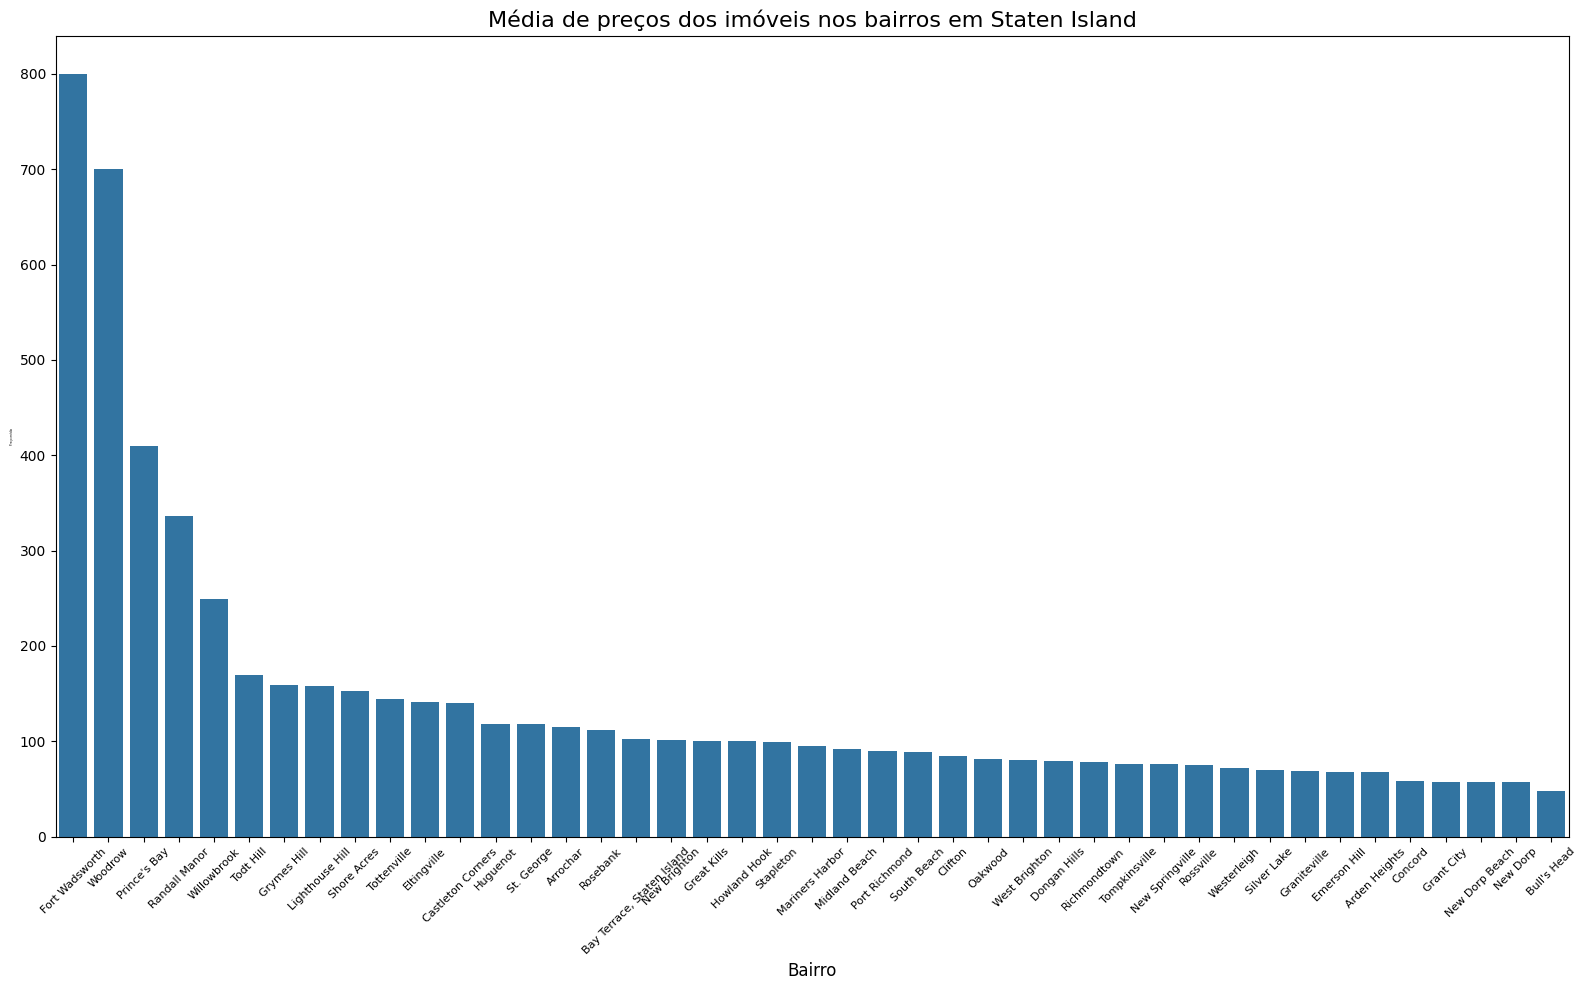

In [424]:
df_media_precos_Stanten = df[df['bairro_group'] == 'Staten Island'].groupby('bairro')['price'].mean().reset_index().sort_values(by='price', ascending=False) 

plt.figure(figsize=(16, 10))
sns.barplot(x='bairro', y='price', data=df_media_precos_Stanten)

plt.title('Média de preços dos imóveis nos bairros em Staten Island', fontsize=16)
plt.xlabel('Bairro', fontsize=12)
plt.ylabel('Preço médio', fontsize=2)

plt.xticks(rotation=45, fontsize=8)
plt.tight_layout()
plt.show()


Plotei abaixo um gráfico de barras descendente dos bairros, o primeiro a ser colocado foi de Staten Island. Nos gráficos cada barra representa a média de preços do bairro, observei que em Staten Island os dois bairros com a maior média de preços e verifiquei o nome dos anúncios desses dois, e claro que no bairro com a maior média tinha o nome Manhattan. Muito provavelmente a concentração de imóveis em Staten Island, não somente os mais caros é em torno de algum ferry que deve estar em torno nas coordenadas 40,65 e -74 se for observar o gráfico de bolha feito anteriormente.

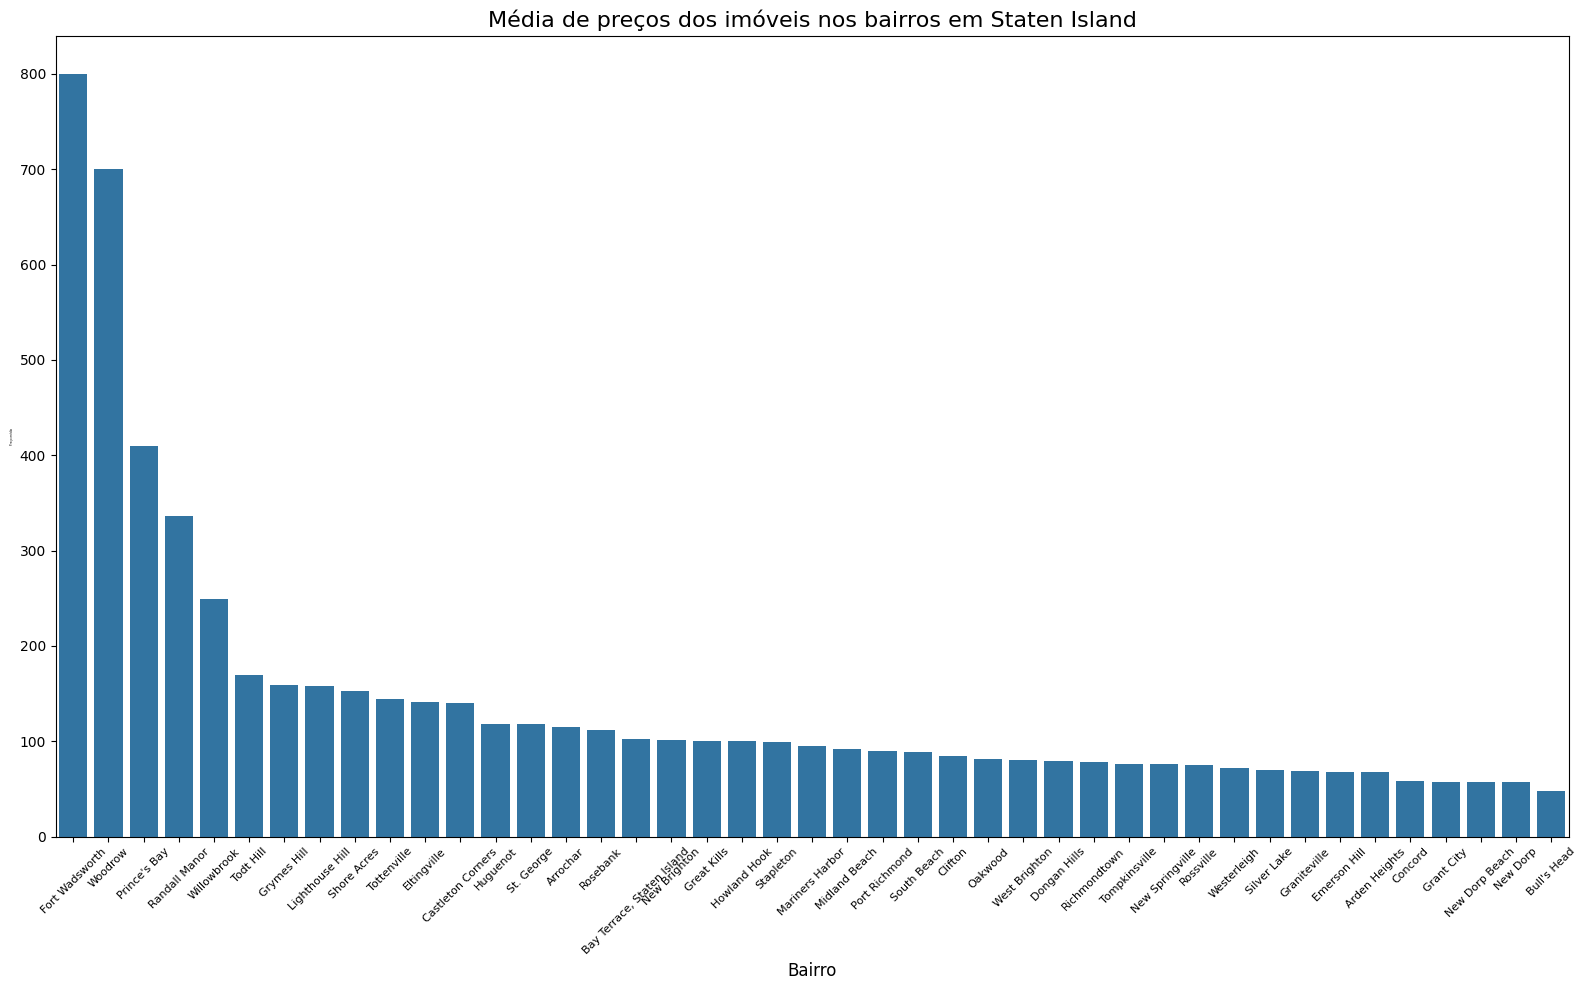

In [425]:
df_media_precos_Stanten = df[df['bairro_group'] == 'Staten Island'].groupby('bairro')['price'].mean().reset_index().sort_values(by='price', ascending=False) 

plt.figure(figsize=(16, 10))
sns.barplot(x='bairro', y='price', data=df_media_precos_Stanten)

plt.title('Média de preços dos imóveis nos bairros em Staten Island', fontsize=16)
plt.xlabel('Bairro', fontsize=12)
plt.ylabel('Preço médio', fontsize=2)

plt.xticks(rotation=45, fontsize=8)
plt.tight_layout()
plt.show()


In [426]:
df[(df['bairro']=='Fort Wadsworth') | (df['bairro'] == 'Woodrow')]

,id,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
3048,1798271,Spacious center hall colonial,9430973,Donna,Staten Island,Woodrow,40.53884,-74.19826,Entire home/apt,700,7,0,NaN,NaN,1,0
25385,20305160,Beach House Retreat. 15 minutes from Manhattan.,1715301,Mark,Staten Island,Fort Wadsworth,40.59546,-74.06092,Entire home/apt,800,7,0,NaN,NaN,3,365


O grupo de bairros Bronx claramente são bairros mais pobres, a média está melhor que Staten Island pois creio que não precise de um ferry para Manhattan pela forma que os imóveis estão distribuídos no mapa. O anúnico mais frequente é "Prolonged Traveler's Dream (a month first & more)", dando a entender que é o melhor local para os viagens ficarem longas temporadas, e nisso o bairro com a maior moda é o KingsBridge e como podemos observar no gráfico de barras, ele não é um bairro com média de preços altas. Também possui 40 citações há Manhattan no nome de anúncios.

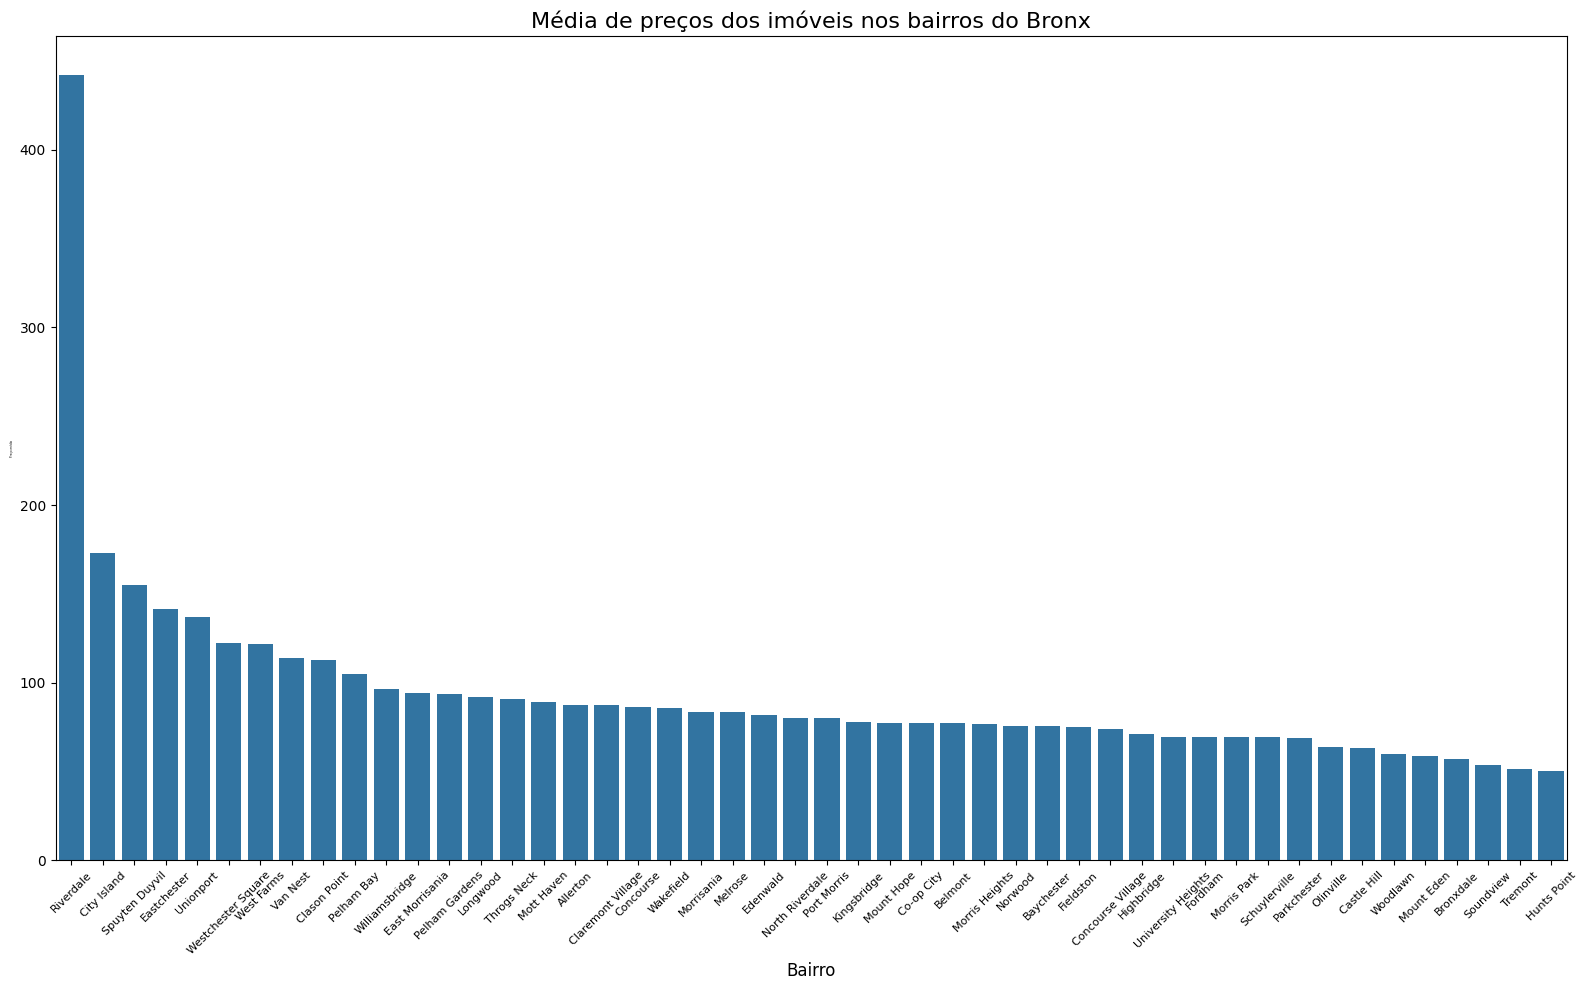

In [427]:

#Selecionou bairro, agrupou e calculou a média de preços, em seguida ordenei da maior média 
df_media_precos_Bronx = df[df['bairro_group'] == 'Bronx'].groupby('bairro')['price'].mean().reset_index().sort_values(by='price', ascending=False) 

plt.figure(figsize=(16, 10))
sns.barplot(x='bairro', y='price', data=df_media_precos_Bronx)

plt.title('Média de preços dos imóveis nos bairros do Bronx', fontsize=16)
plt.xlabel('Bairro', fontsize=12)
plt.ylabel('Preço médio', fontsize=2)

plt.xticks(rotation=45, fontsize=8)
plt.tight_layout()
plt.show()


In [428]:
df[df['bairro_group'] == 'Bronx']['nome'].str.count(r'Manhattan').sum()

np.float64(40.0)

Verifiquei quais são os bairros do Bronx estão contidos no somatório acima, o bairro com a maior média é Riverdale mas os anúncios não estão em sua maioria lá e sim em Mott Haven que não é um bairro tão caro, por isso selecionei a parte para ver a proximidade dos imóveis de Manhattan. Dos 48 bairros do Bronx, 22 tem anúncios referentes a manhataan e aos plotar-los no mapa podemos ver que eles estão circundando o grupo.



In [429]:
#Selecionei o grupo de bairro do brox e usei iloc para localizar os registros que continham Manhattan e depois agrupei por bairro para exibir a quantidade de imóveis
df_g = df[df['bairro_group'] == 'Bronx'].loc[lambda x: x['nome'].str.contains(r'Manhattan', na=False)].groupby('bairro').size().reset_index(name='quantidade')
df_g


,bairro,quantidade
0,Belmont,1
1,Claremont Village,1
2,Concourse,3
3,Concourse Village,3
4,East Morrisania,2
5,Highbridge,1
6,Hunts Point,1
7,Kingsbridge,2
8,Longwood,3
9,Melrose,1


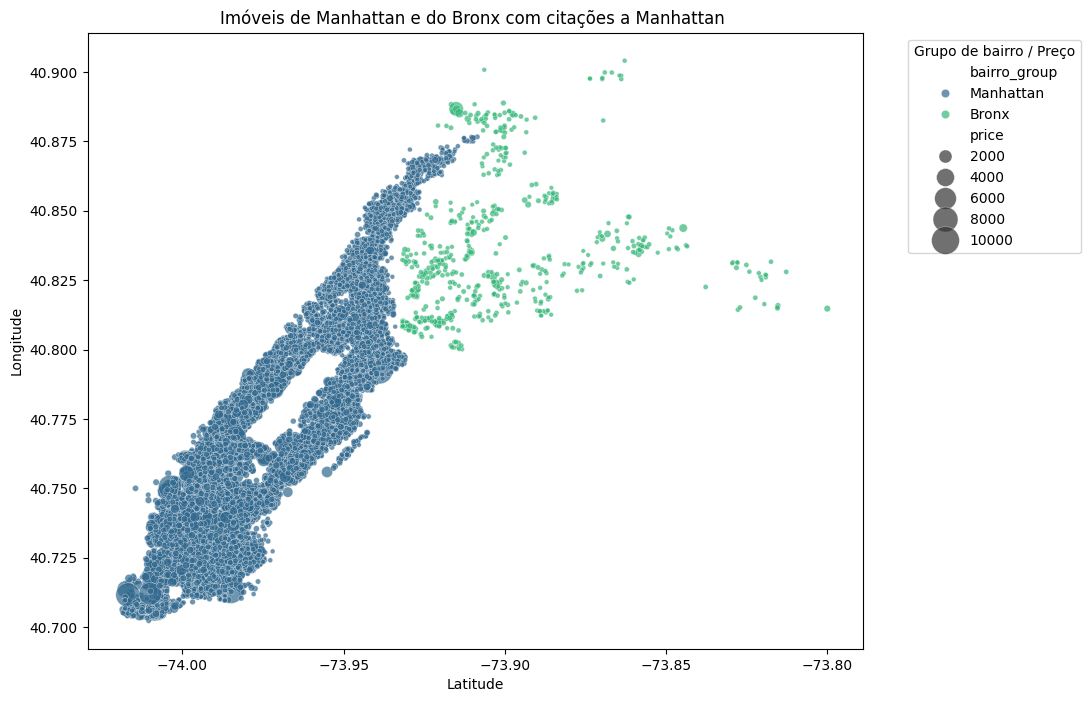

In [430]:
df_bronx = df[(df['bairro_group'] == 'Manhattan') | (df['bairro'].isin(df_g['bairro']))]

plt.figure(figsize=(10, 8))

sns.scatterplot(
    data=df_bronx, x='longitude', y='latitude', 
    size='price', sizes=(10, 400), hue='bairro_group', palette='viridis', alpha=0.7
)

plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.title("Imóveis de Manhattan e do Bronx com citações a Manhattan ")
plt.legend(title='Grupo de bairro / Preço', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

Ao olhar o Brooklyn as citações a Manhattan aumentaram, e o bairro mais "nobre", por ter a maior média de preços, é o Sea Gate mas ele não aparece na lista de bairros com anúncios em citações a Manhattan, ele é um bairro nobre por outros motivos mas não por Manhattan, todavia ao descrever as estátisticas desses bairros vemos que possuem uma média maior do que a média geral do Brooklyn. Além disso os anúncios descrevem sempre o quão próximo de Manhattan estão, a moda de anuncios é "Your Manhattan Home: 12 mins to NYC", entre outros citando estações e outras caracteristicas que aproximam de Manhattan

In [431]:
df[df['bairro_group'] == 'Brooklyn']['nome'].str.count(r'Manhattan').sum()

np.float64(604.0)

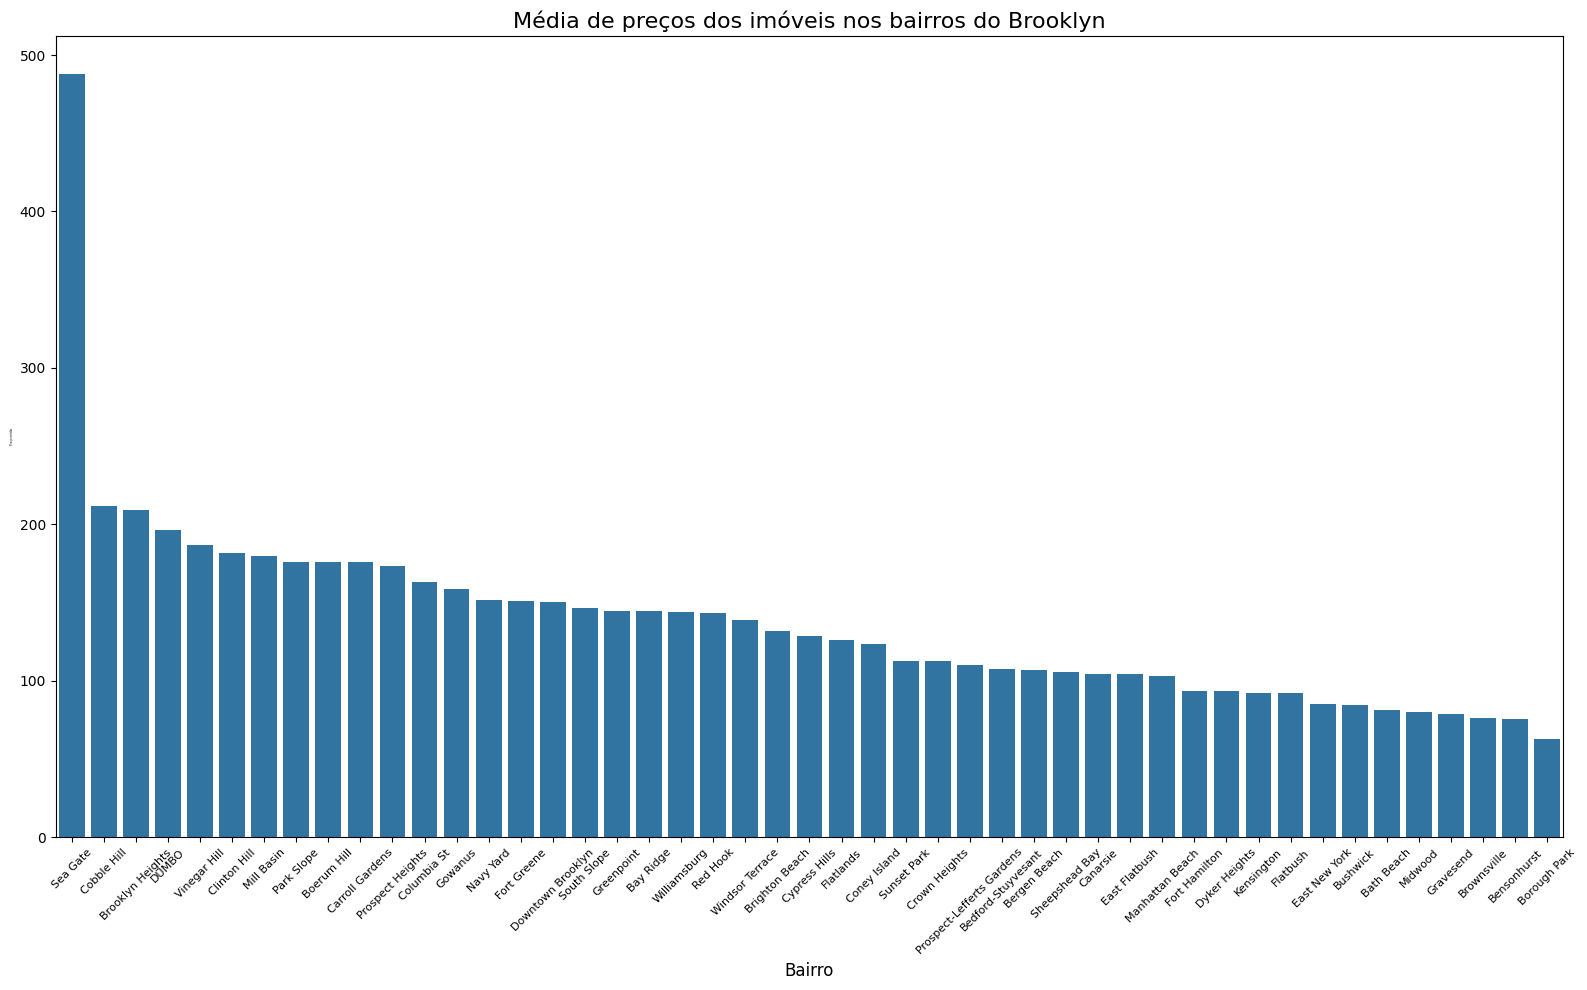

In [432]:
df_media_precos_Brooklyn = df[df['bairro_group'] == 'Brooklyn'].groupby('bairro')['price'].mean().reset_index().sort_values(by='price', ascending=False) 

plt.figure(figsize=(16, 10))
sns.barplot(x='bairro', y='price', data=df_media_precos_Brooklyn)

plt.title('Média de preços dos imóveis nos bairros do Brooklyn', fontsize=16)
plt.xlabel('Bairro', fontsize=12)
plt.ylabel('Preço médio', fontsize=2)

plt.xticks(rotation=45, fontsize=8)
plt.tight_layout()
plt.show()


In [433]:
df_b = df[df['bairro_group'] == 'Brooklyn'].loc[lambda x: x['nome'].str.contains(r'Manhattan', na=False)].groupby('bairro').size().reset_index(name='quantidade')
df_b


,bairro,quantidade
0,Bath Beach,3
1,Bay Ridge,3
2,Bedford-Stuyvesant,155
3,Bensonhurst,5
4,Bergen Beach,1
5,Boerum Hill,2
6,Borough Park,10
7,Brighton Beach,1
8,Brooklyn Heights,5
9,Brownsville,2


In [434]:
df[df['bairro_group'] == 'Brooklyn'].loc[lambda x: x['nome'].str.contains(r'Manhattan', na=False)].describe()

,id,host_id,latitude,longitude,price,minimo_noites,numero_de_reviews,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
count,6.040000e+02,6.040000e+02,604.000000,604.000000,604.000000,604.000000,604.000000,515.000000,604.000000,604.000000
mean,2.150526e+07,8.839946e+07,40.685762,-73.948648,138.824503,6.087748,32.458609,1.847456,2.817881,122.761589
std,1.011675e+07,8.756178e+07,0.027444,0.026697,416.311445,15.450254,49.809454,1.762518,5.501992,127.913759
min,6.848000e+03,1.599100e+04,40.577550,-74.037390,20.000000,1.000000,0.000000,0.020000,1.000000,0.000000
25%,1.473624e+07,1.301554e+07,40.675305,-73.960238,60.000000,2.000000,1.000000,0.340000,1.000000,0.000000
50%,2.206304e+07,4.942172e+07,40.688350,-73.946995,87.500000,2.000000,9.000000,1.340000,1.000000,73.500000
75%,3.023152e+07,1.610333e+08,40.704693,-73.931150,150.000000,4.000000,42.250000,2.880000,3.000000,228.500000
max,3.642246e+07,2.711629e+08,40.737600,-73.869610,10000.000000,200.000000,314.000000,10.560000,103.000000,365.000000


In [435]:
df[df['bairro_group'] == 'Brooklyn'].loc[lambda x: x['nome'].str.contains(r'Manhattan', na=False)].select_dtypes(exclude='number').describe()

,nome,host_name,bairro_group,bairro,room_type,ultima_review
count,604,604,604,604,604,515
unique,603,416,1,38,3,213
top,Your Manhattan Home: 12 mins to NYC,Sergii,Brooklyn,Bedford-Stuyvesant,Private room,2019-06-23
freq,2,9,604,155,320,25


In [436]:
df[df['bairro_group'] == 'Brooklyn'].loc[lambda x: x['nome'].str.contains(r'Manhattan', na=False)]

,id,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
14,6848,Only 2 stops to Manhattan studio,15991,Allen & Irina,Brooklyn,Williamsburg,40.70837,-73.95352,Entire home/apt,140,2,148,2019-06-29,1.20,1,46
408,135465,Garden apartment close to Manhattan,663879,Christopher,Brooklyn,Fort Greene,40.68626,-73.97598,Entire home/apt,170,3,86,2019-06-20,0.91,2,286
541,197942,"Comfy, Cozy, Brooklyn close to Manhattan",289135,Toni,Brooklyn,Bedford-Stuyvesant,40.68497,-73.95592,Entire home/apt,99,3,207,2019-07-07,2.18,1,304
595,225887,Brooklyn B & B close to Manhattan,663879,Christopher,Brooklyn,Fort Greene,40.68645,-73.97538,Private room,130,3,154,2019-06-19,1.63,2,305
624,236671,"Williamsburg Garden Home, 5 minutes from Manha...",1240820,Triny,Brooklyn,Williamsburg,40.71746,-73.95497,Entire home/apt,180,2,125,2019-07-06,1.36,3,248
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48436,36266639,Small and Cozy room only 4 stations to Manhattan!,242573463,Filipe,Brooklyn,Bedford-Stuyvesant,40.69685,-73.94372,Private room,77,2,0,NaN,NaN,7,169
48439,36267230,Spacious bedroom only 4 stations to Manhattan!,242573463,Filipe,Brooklyn,Bedford-Stuyvesant,40.69630,-73.94365,Private room,77,2,0,NaN,NaN,7,170
48441,36267904,Gorgeous bedroom in Brooklyn close to Manhattan!,242573463,Filipe,Brooklyn,Bedford-Stuyvesant,40.69684,-73.94257,Private room,77,2,0,NaN,NaN,7,168
48443,36268350,Beautiful Brooklyn room close to Manhattan!,242573463,Filipe,Brooklyn,Bedford-Stuyvesant,40.69653,-73.94213,Private room,77,2,0,NaN,NaN,7,147


Ao analisar a média dos preços de imóveis por bairro, observamos que os bairros de Manhattan tem médias mais elevadas quando comparados aos outros três. Entre os cinco bairros com a menor taxa de preço, está o Harlem que possui a maior moda da base de dados, é o bairro com mais anúncios. Olhando a tabela de descrição com apenas esse cinco bairros, pela distribuição dos quartis da latitude e longitude podemos perceber que eles ficam parte mais acima do mapa de Manhattan, indo para o Bronx. Se uma pessoa fosse investir na compra de um imóvel para a plataforma seria em um desses bairros de Manhattan, devido a expeculação imobiliária em cima do grupo de bairro. Outra opção é a compra de imóveis mais baratos no Bronx proxímos a Manhattan 

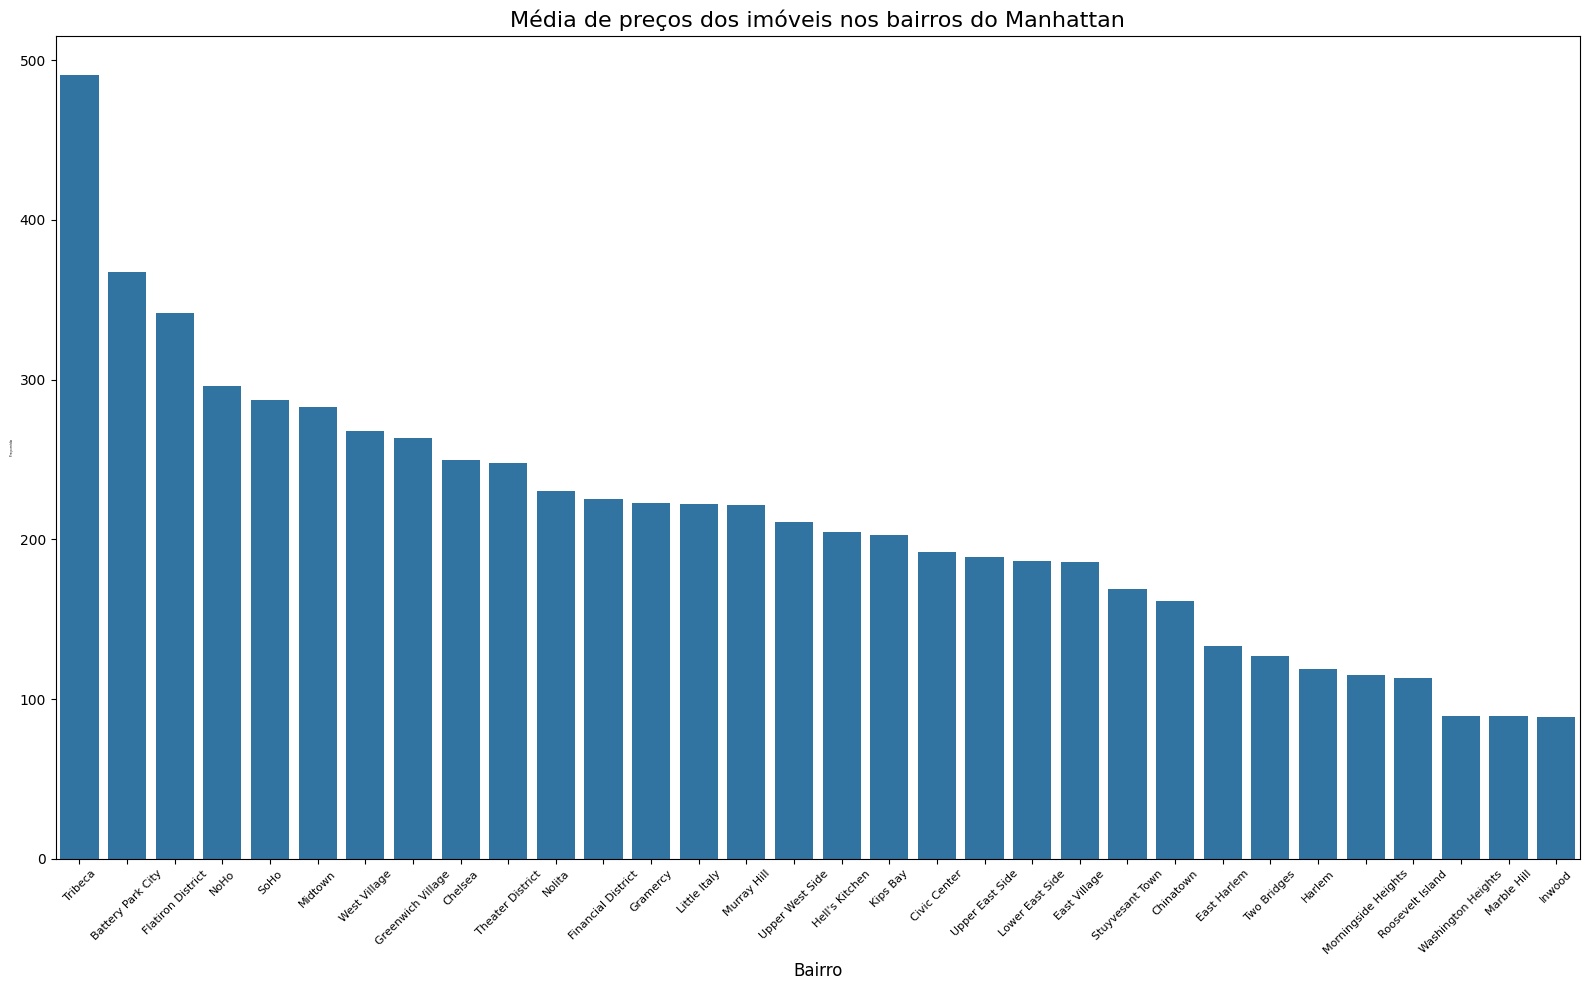

In [437]:
df_media_precos_Manhattan = df[df['bairro_group'] == 'Manhattan'].groupby('bairro')['price'].mean().reset_index().sort_values(by='price', ascending=False) 

plt.figure(figsize=(16, 10))
sns.barplot(x='bairro', y='price', data=df_media_precos_Manhattan)

plt.title('Média de preços dos imóveis nos bairros do Manhattan', fontsize=16)
plt.xlabel('Bairro', fontsize=12)
plt.ylabel('Preço médio', fontsize=2)

plt.xticks(rotation=45, fontsize=8)
plt.tight_layout()
plt.show()


In [438]:
m_bairros = ['Harlem','Morningside Heights','Roosevelt Island','Washington Heights','Marble Hill','Inwood']
df[df['bairro'].isin(m_bairros)].describe()

,id,host_id,latitude,longitude,price,minimo_noites,numero_de_reviews,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
count,4.244000e+03,4.244000e+03,4244.000000,4244.000000,4244.000000,4244.000000,4244.000000,3458.000000,4244.000000,4244.000000
mean,1.791195e+07,6.082612e+07,40.823569,-73.945607,110.438501,6.313384,24.456645,1.258690,2.059142,98.708530
std,1.079798e+07,7.091355e+07,0.019754,0.009552,133.021630,22.253236,45.967523,1.484633,5.929990,123.885714
min,3.647000e+03,4.632000e+03,40.755920,-73.967790,10.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,8.679373e+06,8.588278e+06,40.809197,-73.952500,60.000000,1.000000,1.000000,0.170000,1.000000,0.000000
50%,1.815486e+07,3.124118e+07,40.821445,-73.945620,85.000000,2.000000,6.000000,0.650000,1.000000,30.000000
75%,2.726140e+07,8.352017e+07,40.834280,-73.940310,125.000000,5.000000,27.000000,1.880000,2.000000,188.000000
max,3.648543e+07,2.736442e+08,40.876650,-73.908550,5000.000000,999.000000,607.000000,10.000000,103.000000,365.000000


## b) O número mínimo de noites e a disponibilidade ao longo do ano interferem no preço?

Pensando inicialmente faria sentindo o número mínimo de noites e a disponibilidade interferir no preço, pois inferem no número de dias que um inquilino ficara com o imóvel. Uma forma de verificar isso é com correlação. todavia as relações de correlação são fracas entre os atributos númericos. Inicialmente usei a correlação de person que ela se baseia na linearidade, mas vemos que não temos relações de correlação forte o que já era esperado pois os dados não estão normalmente distribuídos 

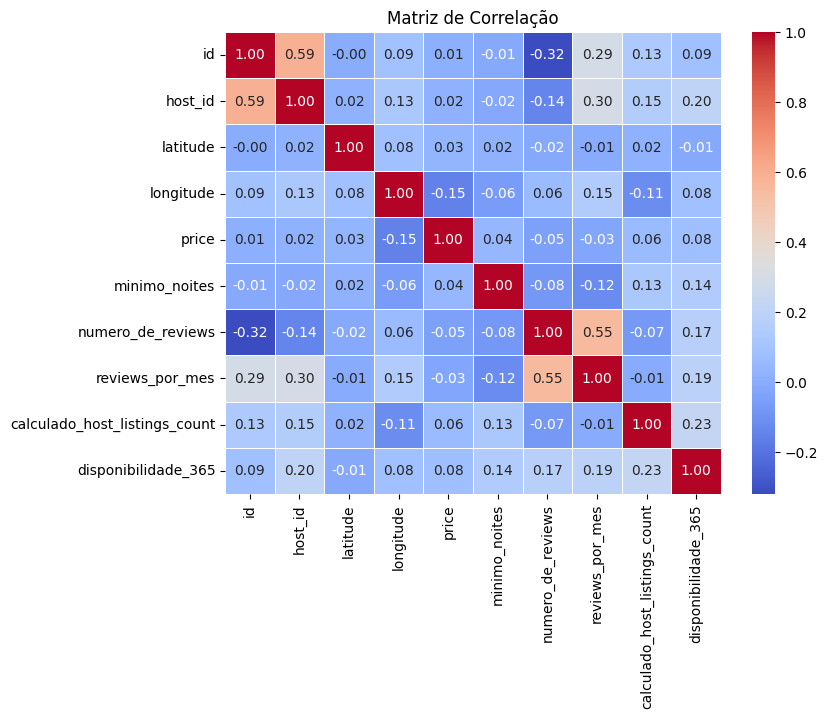

In [439]:
corr_matrix = df.select_dtypes(include=['number']).corr()

# Plotar matriz com heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)

plt.title("Matriz de Correlação")
plt.show()

Sabemos que pela distribuições dos quartis nas tabelas, a distribuição dos nossos dados númericos é praticamente unilateral esquerda, a buscar a matriz de correlação apliquei o método de Sperman, pois os dados não são lineares quando olhamos a distribuição dos preços dos alugueis por bairro, testei com o método de Person anteriormente mas não teve resultados bons. Embora a de Spearman identificou a correlação negativa consideravel entre longitude e o preço, quando olhamos no mapa podemos perceber que é válida e temos correlação, enquanto a latitude, existe alguma relação é mas é fraca e faz sentindo pois os imóveis de valores altos estão no meio do mapa.

Outra observação é que existe alguma correlação entre disponibilidade e as reviews, um ímovel com mais disponibilidade aparentemente tem mais reviews pois deve ter recebido mais hospedes. Da mesma forma da correlação positiva entre disponibilidade e calculado_host_count pois um anfitrião com mais imóveis vai ter maior disponibilidade. Mas o ponto é que Sperman e nem Person vão identificar essa real relação pois temos atributos discretos.

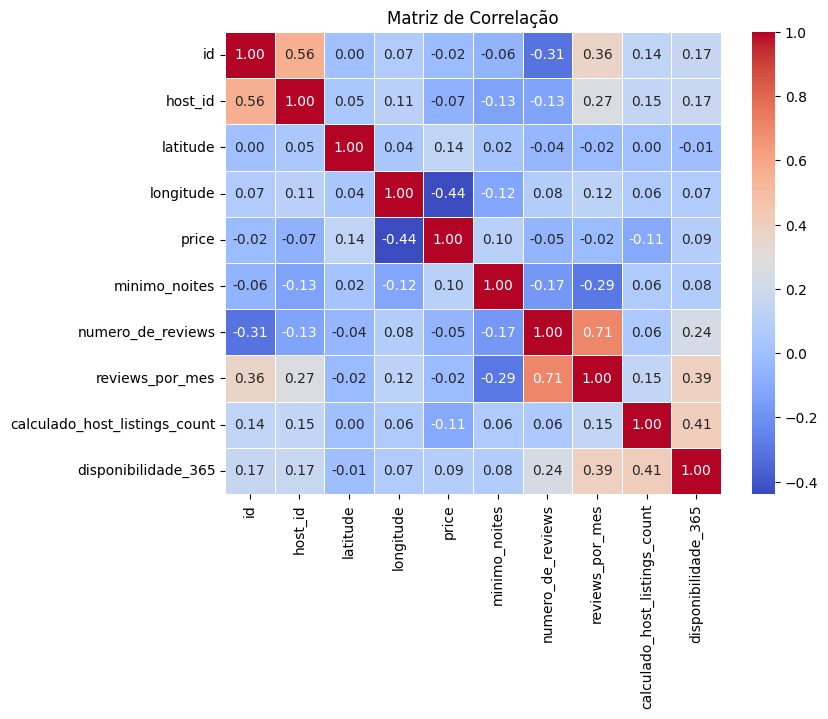

In [440]:
corr_matrix = df.select_dtypes(include=['number']).corr(method='spearman')


# Plotar matriz com heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)

plt.title("Matriz de Correlação")
plt.show()

Tentei inicialmente por algumns métodos de linearização, joguei na escala logaritmitca e não funcionou, verifiquei com algumas transformações do sklearn mas nada que tivesse resultados satisfatórios, até por fim lembrei que já havia passado por um problema semelhante durante a disciplina de estatística e verifiquei se era possível aplicar um teste de hipótese. Assim apliquei um Qui-quadrado para verificar se possui relação, e aparentemente sim pelo resultado do teste. Mas por ser uma relação não linear, não está claro totalemtne essas relações, por exemplo se a medida que a disponibilidade aumenta o preço cai ou sobe por exemplo.

Observamos que o valor do X² é alto, o que significa maior discrepância entre os dados observados e esperados, como é diferente de zero quer dizer que há associação entre as variaveis. Juntamente com o valor tão baixo de p.



In [441]:
tabela_contingencia = pd.crosstab([df['price'], df['disponibilidade_365']], df['minimo_noites'])

chi2, p, dof, expected = chi2_contingency(tabela_contingencia)

print(f"Qui-quadrado: {chi2}")
print(f"Valor p: {p}")
print(f"Graus de liberdade: {dof}")
print(f"Frequências esperadas:\n{expected}")

# Decisão baseada no valor p
alpha = 0.05
if p < alpha:
    print("Rejeita-se a hipótese nula: As variáveis não são independentes.")
else:
    print("Não se rejeita a hipótese nula: As variáveis são independentes.")


Qui-quadrado: 2254537.563705246
Valor p: 0.0
Graus de liberdade: 2071656
Frequências esperadas:
[[2.08105067e+00 1.91363051e+00 1.30892130e+00 ... 4.90968230e-04
  1.63656077e-04 1.63656077e-04]
 [2.60131334e-01 2.39203813e-01 1.63615163e-01 ... 6.13710288e-05
  2.04570096e-05 2.04570096e-05]
 [2.60131334e-01 2.39203813e-01 1.63615163e-01 ... 6.13710288e-05
  2.04570096e-05 2.04570096e-05]
 ...
 [2.60131334e-01 2.39203813e-01 1.63615163e-01 ... 6.13710288e-05
  2.04570096e-05 2.04570096e-05]
 [5.20262668e-01 4.78407626e-01 3.27230325e-01 ... 1.22742058e-04
  4.09140192e-05 4.09140192e-05]
 [2.60131334e-01 2.39203813e-01 1.63615163e-01 ... 6.13710288e-05
  2.04570096e-05 2.04570096e-05]]
Rejeita-se a hipótese nula: As variáveis não são independentes.


## c) Existe algum padrão no nome dos locais de alto valor?

Primeiramente definindo que os locais de alto valor são acima de $1000,00. Verificando que a maioria deles se localizam em Manhattan, como já tinhamos observamos nos histogramas. 

In [442]:
high_price_df = df[df['price'] > 1000]
high_price_df.head()

,id,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
495,174966,Luxury 2Bed/2.5Bath Central Park View,836168,Henry,Manhattan,Upper West Side,40.77350,-73.98697,Entire home/apt,2000,30,30,2018-05-05,0.33,11,0
761,273190,6 Bedroom Landmark West Village Townhouse,605463,West Village,Manhattan,West Village,40.73301,-74.00268,Entire home/apt,1300,5,28,2018-09-25,0.31,4,297
945,363673,Beautiful 3 bedroom in Manhattan,256239,Tracey,Manhattan,Upper West Side,40.80142,-73.96931,Private room,3000,7,0,NaN,NaN,1,365
1104,468613,$ (Phone number hidden by Airbnb) weeks - room f,2325861,Cynthia,Manhattan,Lower East Side,40.72152,-73.99279,Private room,1300,1,0,NaN,NaN,1,0
1479,664047,Lux 2Bed/2.5Bath Central Park Views,836168,Henry,Manhattan,Upper West Side,40.77516,-73.98573,Entire home/apt,2000,30,59,2016-01-28,0.71,11,364


In [443]:
high_price_df.groupby('bairro_group').size().reset_index()

,bairro_group,0
0,Bronx,1
1,Brooklyn,54
2,Manhattan,172
3,Queens,10
4,Staten Island,2


In [444]:
high_price_df[(df['bairro_group'] =='Bronx') | (df['bairro_group'] =='Staten Island') | (df['bairro_group'] =='Queens')].groupby('bairro').size().reset_index() 

C:\Users\larae\AppData\Local\Temp\ipykernel_24736\2373796755.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  high_price_df[(df['bairro_group'] =='Bronx') | (df['bairro_group'] =='Staten Island') | (df['bairro_group'] =='Queens')].groupby('bairro').size().reset_index()


,bairro,0
0,Arverne,1
1,Astoria,4
2,Bayside,1
3,Flushing,1
4,Forest Hills,1
5,Long Island City,2
6,Prince's Bay,1
7,Randall Manor,1
8,Riverdale,1


In [445]:
high_price_df[df['bairro_group'] =='Brooklyn'].groupby('bairro').size().reset_index()

C:\Users\larae\AppData\Local\Temp\ipykernel_24736\3264236424.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  high_price_df[df['bairro_group'] =='Brooklyn'].groupby('bairro').size().reset_index()


,bairro,0
0,Bay Ridge,2
1,Bedford-Stuyvesant,10
2,Brighton Beach,1
3,Brooklyn Heights,2
4,Bushwick,1
5,Carroll Gardens,1
6,Clinton Hill,3
7,Cobble Hill,1
8,Columbia St,1
9,Crown Heights,3


In [446]:
high_price_df[df['bairro_group'] =='Manhattan'].groupby('bairro').size().reset_index()

C:\Users\larae\AppData\Local\Temp\ipykernel_24736\4147745066.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  high_price_df[df['bairro_group'] =='Manhattan'].groupby('bairro').size().reset_index()


,bairro,0
0,Battery Park City,2
1,Chelsea,13
2,Chinatown,1
3,East Harlem,4
4,East Village,12
5,Financial District,2
6,Flatiron District,4
7,Gramercy,6
8,Greenwich Village,7
9,Harlem,5


In [447]:
nlp = spacy.load('en_core_web_sm')

In [460]:
localidades = []

for anuncio in high_price_df['nome']:
    doc = nlp(anuncio)
    localidades.extend([ent.text for ent in doc.ents if ent.label_ == "LOC"])

localidades


['NYC SuperBowl',
 'Columbus Circle',
 'the Flatiron District',
 'Harlem',
 'NYC',
 'NYC',
 'NYC',
 'the Financial District',
 'Harlem',
 'Central Park',
 'Hudson',
 'Midtown East']

Usei a biblioteca spacy para gerar tokens e verificar em cada registro quais tokens são localidades, encontramos os padrões do Harlem, o Hudson, Midtown East, Central Park, Distrito Financeiro, Columbus Circle, NYC, the Flatiron District. NYC SuperBowl não é uma localidade, mas sim o campeonato de futebool americano, o que provalvemente faz com que os imóveis estejam proxímos de algum estádio

In [467]:
localidades = []

for anuncio in high_price_df['nome']:
    doc = nlp(anuncio)
    localidades.extend([ent.text.lower() for ent in doc.ents if ent.label_ in ["LOC", 'GPE', 'PLACE']])

localidades


['west village',
 'manhattan',
 'west village penthouse',
 'cp',
 'nyc superbowl',
 'superbowl',
 'sqft',
 'superbowl',
 'the west village',
 'manhattan',
 'new york',
 'columbus circle',
 'flatiron',
 'east village',
 'williamsburg',
 'brooklyn',
 'cozy',
 'brooklyn',
 'astoria',
 'tribeca',
 'new york',
 'new york city',
 'williamsburg',
 'greenwich village',
 'hells kitchen nyc',
 'manhattan',
 'the flatiron district',
 'midtown',
 'manhattan',
 'midtown',
 'harlem',
 'manhattan',
 'manhattan',
 'west village',
 'nyc',
 'nyc',
 'manhattan',
 'manhattan',
 'rockaway beach',
 'comfort',
 'manhattan',
 'downtown',
 'manhattan',
 'manhattan',
 'nyc',
 'chelsea',
 'shoots',
 'williamsburg',
 'shoots',
 'williamsburg',
 'west village',
 'boerum hill',
 'brooklyn',
 'brooklyn',
 'the financial district',
 'new york',
 'ventura',
 'west village',
 'east village',
 'new york',
 'crown heights',
 'alphabet city',
 'west village',
 'harlem',
 'manhattan',
 'wyndham',
 'new york city',
 'flatir

In [468]:
contagem = Counter(localidades)

In [469]:
df_contagem = pd.DataFrame(contagem.items(), columns=["Localidade", "Frequência"])

df_contagem = df_contagem.sort_values(by="Frequência", ascending=False)
df_contagem

,Localidade,Frequência
1,manhattan,13
0,west village,6
13,brooklyn,5
8,new york,4
12,williamsburg,4
23,nyc,3
11,east village,2
5,superbowl,2
17,new york city,2
14,cozy,2


O que podemos observar nas palavras, a presença de Manhattan, West Village, East Village, Williamsburg, Brooklyn. A palavra Midtown aparece em diferentes pontos, o nome de bairros nobres como o Tribeca e o Astoria. Outra coisa é a presença da palavra Superbowl que não é uma localização mas sim um campeonato de futebol americano, o que indica que esses imóveis mais caros podem estar próximos a um estádio e tem a questão de turismo e movimento na época dos jogos. O que está superfaturando os valores de alguns  imóveis